<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PR</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Práctica: Clasificador Neuronal para la detección de Glaucoma

* [Análisis Exploratorio de datos](#Sección-1:-Análisis-Exploratorio-de-datos)

* [Entrenamiento de una red neuronal sobre una única partición](#Sección-2:-Entrenamiento-de-una-red-neuronal-sobre-una-única-partición)
    - Modelo 1
    - Modelo 2
    - Modelo 3
    - Modelo 4
    - Modelo 5

Importamos las librerías necesarias

In [68]:
from glob import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras import Model
#import tensorflow_addons as tfa 

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, Dropout, MaxPooling2D, GlobalMaxPooling2D


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score


import re

In [69]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [70]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [71]:
%cd /content/drive/MyDrive/UOC-DataScience/DL_Operativa/PR/

/content/drive/MyDrive/UOC-DataScience/DL_Operativa/PR


In [5]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [6]:
import tensorflow_addons as tfa

Generamos una lista con todas las carpetas que contienen los ficheros de las imágenes 

In [7]:
folders = glob("data/practica_DL_UOC_2022/*", recursive = True)
folders

['data/practica_DL_UOC_2022/Fold3',
 'data/practica_DL_UOC_2022/Fold7',
 'data/practica_DL_UOC_2022/Fold9',
 'data/practica_DL_UOC_2022/Fold1',
 'data/practica_DL_UOC_2022/Fold0',
 'data/practica_DL_UOC_2022/Fold2',
 'data/practica_DL_UOC_2022/Fold4',
 'data/practica_DL_UOC_2022/Fold8',
 'data/practica_DL_UOC_2022/Fold5',
 'data/practica_DL_UOC_2022/Fold6']

Armamos un df que contenga el path y la condición de cada imágen del dataset

In [8]:
data = []


for i in folders:
    
    folder = i[-5:]
    
    test_normal = glob(i + "/test/normal/*", recursive = True)
    df_TestNormal = pd.DataFrame(test_normal, columns=["ImgsPaths"])
    df_TestNormal["Folder"] = folder
    df_TestNormal["Train_Test_Valid"] = "test"
    df_TestNormal["Condition"] = "normal"
    data.append(df_TestNormal)
    
    test_abnormal = glob(i + "/test/abnormal/*", recursive = True)
    df_test_abnormal = pd.DataFrame(test_abnormal, columns=["ImgsPaths"])
    df_test_abnormal["Folder"] = folder
    df_test_abnormal["Train_Test_Valid"] = "test"
    df_test_abnormal["Condition"] = "abnormal"
    data.append(df_test_abnormal)
    
    
    train_normal = glob(i + "/train/normal/*", recursive = True)
    df_train_normal = pd.DataFrame(train_normal, columns=["ImgsPaths"])
    df_train_normal["Folder"] = folder
    df_train_normal["Train_Test_Valid"] = "train"
    df_train_normal["Condition"] = "normal"
    data.append(df_train_normal)
    
    train_abnormal = glob(i + "/train/abnormal/*", recursive = True)
    df_train_abnormal = pd.DataFrame(train_abnormal, columns=["ImgsPaths"])
    df_train_abnormal["Folder"] = folder
    df_train_abnormal["Train_Test_Valid"] = "train"
    df_train_abnormal["Condition"] = "abnormal"
    data.append(df_train_abnormal)
    
    valid_normal = glob(i + "/valid/normal/*", recursive = True)
    df_valid_normal = pd.DataFrame(valid_normal, columns=["ImgsPaths"])
    df_valid_normal["Folder"] = folder
    df_valid_normal["Train_Test_Valid"] = "valid"
    df_valid_normal["Condition"] = "normal"
    data.append(df_valid_normal)
    
    
    valid_abnormal = glob(i + "/valid/abnormal/*", recursive = True)
    df_valid_abnormal = pd.DataFrame(valid_abnormal, columns=["ImgsPaths"])
    df_valid_abnormal["Folder"] = folder
    df_valid_abnormal["Train_Test_Valid"] = "valid"
    df_valid_abnormal["Condition"] = "abnormal"
    data.append(df_valid_abnormal)

In [9]:
df = pd.concat(data)

In [10]:
df.head()

,ImgsPaths,Folder,Train_Test_Valid,Condition
0,data/practica_DL_UOC_2022/Fold3/test/normal/RJkbMYUrXl.jpg,Fold3,test,normal
1,data/practica_DL_UOC_2022/Fold3/test/normal/EMpNLPsRUu.jpg,Fold3,test,normal
2,data/practica_DL_UOC_2022/Fold3/test/normal/zEYMCPLPaq.jpg,Fold3,test,normal
3,data/practica_DL_UOC_2022/Fold3/test/normal/kCChKhUIpS.jpg,Fold3,test,normal
4,data/practica_DL_UOC_2022/Fold3/test/normal/RyGNHJNtHj.jpg,Fold3,test,normal


In [11]:
df.sample(2)

,ImgsPaths,Folder,Train_Test_Valid,Condition
443,data/practica_DL_UOC_2022/Fold7/train/normal/dNYiAoRbvf.jpg,Fold7,train,normal
292,data/practica_DL_UOC_2022/Fold5/train/normal/lSvrPMyLlN.jpg,Fold5,train,normal


Comprobamos que el dataser contiene un total de 17.070 imágenes en total

In [12]:
df.shape

(17090, 4)

# Sección 1: Análisis Exploratorio de datos

Comprobamos el número de imágenes por condición y Folder

In [13]:
df.groupby(["Folder","Train_Test_Valid","Condition"]).count()

ImgsPaths
Folder Train_Test_Valid Condition           
Fold0  test             abnormal   92       
                        normal     82       
       train            abnormal   625      
                        normal     754      
       valid            abnormal   71       
                        normal     83       
Fold1  test             abnormal   83       
                        normal     91       
       train            abnormal   639      
                        normal     740      
       valid            abnormal   66       
                        normal     88       
Fold2  test             abnormal   77       
                        normal     97       
       train            abnormal   650      
                        normal     739      
       valid            abnormal   71       
                        normal     83       
Fold3  test             abnormal   83       
                        normal     91       
       train            abnormal   636      
                        normal     743      
       valid            abnormal   69       
                        normal     85       
Fold4  test             abnormal   82       
                        normal     92       
       train            abnormal   633      
                        normal     746      
       valid            abnormal   73       
                        normal     81       
Fold5  test             abnormal   84       
                        normal     90       
       train            abnormal   621      
                        normal     758      
       valid            abnormal   83       
                        normal     71       
Fold6  test             abnormal   93       
                        normal     81       
       train            abnormal   625      
                        normal     754      
       valid            abnormal   70       
                        normal     84       
Fold7  test             abnormal   74       
                        normal     100      
       train            abnormal   642      
                        normal     737      
       valid            abnormal   72       
                        normal     82       
Fold8  test             abnormal   83       
                        normal     91       
       train            abnormal   631      
                        normal     748      
       valid            abnormal   74       
                        normal     80       
Fold9  test             abnormal   70       
                        normal     104      
       train            abnormal   646      
                        normal     743      
       valid            abnormal   72       
                        normal     82

Comprobamos el número de imágenes por test train y valid

In [ ]:
df.groupby(["Train_Test_Valid","Condition"]).count()

ImgsPaths  Folder
Train_Test_Valid Condition                   
test             abnormal   821        821   
                 normal     919        919   
train            abnormal   6348       6348  
                 normal     7462       7462  
valid            abnormal   721        721   
                 normal     819        819

In [ ]:
df.groupby(["Condition"]).count()

,ImgsPaths,Folder,Train_Test_Valid
Condition,,,
abnormal,7890,7890,7890
normal,9200,9200,9200


In [ ]:
grouped = df.groupby(["Folder","Train_Test_Valid","Condition"]).count().reset_index()

In [ ]:
df.groupby(["Condition"]).count().reset_index()

,Condition,ImgsPaths,Folder,Train_Test_Valid
0,abnormal,7890,7890,7890
1,normal,9200,9200,9200


El dataset contiene mayor cantidad de imágenes en condición normal, sin embargo el dataset no se encuentra desbalanceado

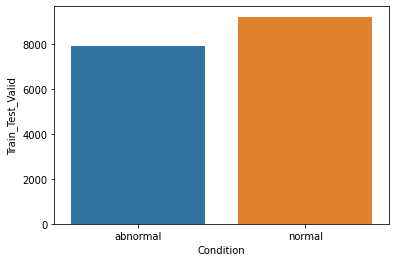

In [ ]:
ax = sns.barplot(x="Condition", y="Train_Test_Valid",data=df.groupby(["Condition"]).count().reset_index())

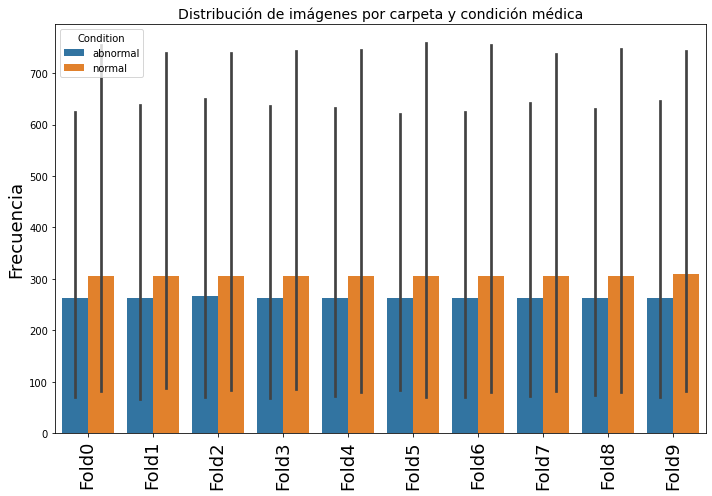

In [ ]:
plt.figure(figsize=(10, 7))
sns.barplot(x="Folder", y="ImgsPaths", hue = "Condition",data=grouped)
plt.xlabel("")
plt.ylabel( "Frecuencia" , size = 18)
plt.title( "Distribución de imágenes por carpeta y condición médica", size = 14)
plt.xticks(rotation=90, size = 18)
plt.tight_layout()
plt.show()

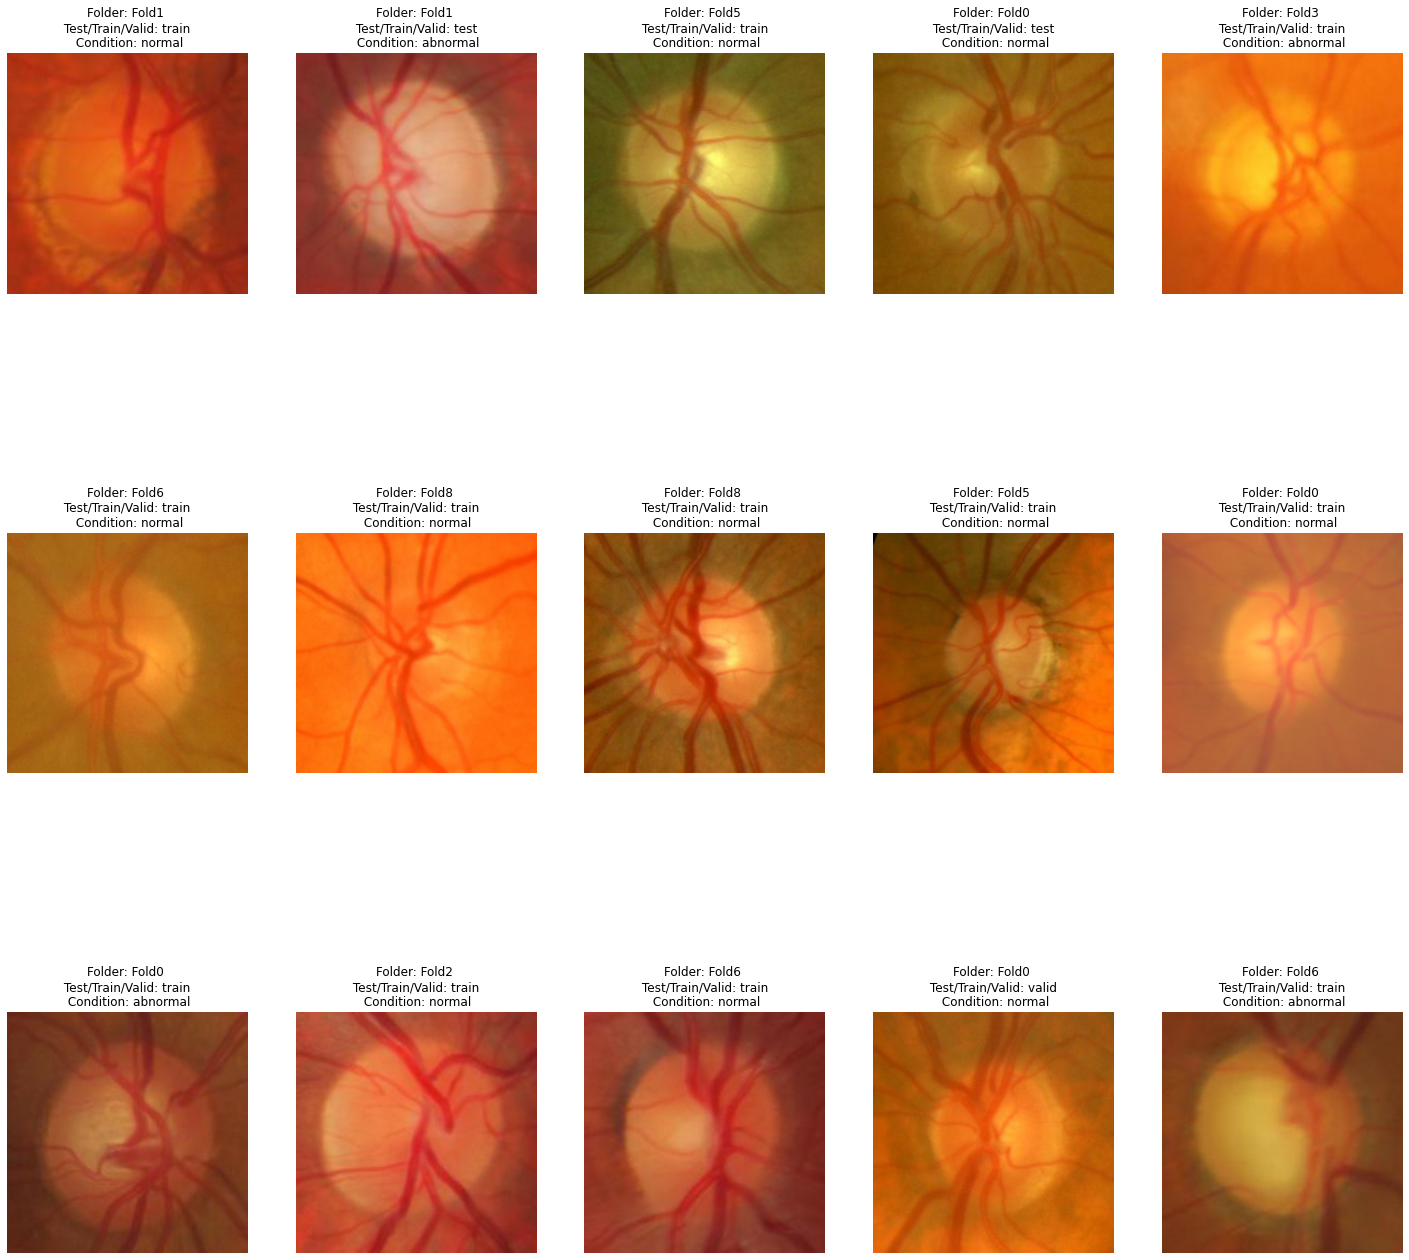

In [ ]:
sample = df.sample(15, random_state=42)

plt.figure(figsize=(25, 25))

for i in range(15):
    img_dir = list(sample["ImgsPaths"])[i]
    img = plt.imread(img_dir)
    folder = list(sample["Folder"])[i]
    Train_Test_Valid = list(sample["Train_Test_Valid"])[i]
    condition =  list(sample["Condition"])[i]
    
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title("Folder: {} \n Test/Train/Valid: {} \n Condition: {}".format(folder, Train_Test_Valid, condition))
    #plt.rcParams.update({'font.size': 20})
    plt.axis("off")
    

Filtramos por el Folder0 para la construcción de los modelos iniciales

In [14]:
Folder0 = df[(df["Folder"] == "Fold0")]
Folder0.head()

,ImgsPaths,Folder,Train_Test_Valid,Condition
0,data/practica_DL_UOC_2022/Fold0/test/normal/LoebaaOsOW.jpg,Fold0,test,normal
1,data/practica_DL_UOC_2022/Fold0/test/normal/RcABuEfFcz.jpg,Fold0,test,normal
2,data/practica_DL_UOC_2022/Fold0/test/normal/XrHrJvrvDv.jpg,Fold0,test,normal
3,data/practica_DL_UOC_2022/Fold0/test/normal/agSTJamWau.jpg,Fold0,test,normal
4,data/practica_DL_UOC_2022/Fold0/test/normal/jArOssjbxh.jpg,Fold0,test,normal


In [15]:
Folder0.shape

(1707, 4)

Desordenamos los datos y reemplazamos por ceros y unos las condiciones normal y abnormal respectivamente

In [16]:
Folder0 = Folder0.sample(Folder0.shape[0], random_state=42)

Folder0['Condition'] = Folder0['Condition'].replace(['normal'], 0)
Folder0['Condition'] = Folder0['Condition'].replace(['abnormal'],1)
Folder0.sample(5)

,ImgsPaths,Folder,Train_Test_Valid,Condition
273,data/practica_DL_UOC_2022/Fold0/train/abnormal/VTHaQnMLQT.jpg,Fold0,train,1
520,data/practica_DL_UOC_2022/Fold0/train/abnormal/nOAijTUzmz.jpg,Fold0,train,1
191,data/practica_DL_UOC_2022/Fold0/train/abnormal/dOzQANWhuR.jpg,Fold0,train,1
193,data/practica_DL_UOC_2022/Fold0/train/normal/JrtgONhiTP.jpg,Fold0,train,0
222,data/practica_DL_UOC_2022/Fold0/train/abnormal/IsiazrnBZe.jpg,Fold0,train,1


Separamos el dataser Folder0 en train, test y valid

In [17]:
testDF = Folder0[Folder0["Train_Test_Valid"] == 'test']
trainDF = Folder0[Folder0["Train_Test_Valid"] == 'train']
validDF = Folder0[Folder0["Train_Test_Valid"] == 'valid']

In [18]:
y_test = tf.keras.utils.to_categorical(np.array(testDF["Condition"]))
y_train = tf.keras.utils.to_categorical(np.array(trainDF["Condition"]))
y_valid = tf.keras.utils.to_categorical(np.array(validDF["Condition"]))

Definimos una función para leer las imágenes en cada path de cada dataset: train, test y valid

In [19]:
def getImages(listPaths):
    listImgs = []
    for i in listPaths:
        img_dir = i
        img = plt.imread(img_dir)
        listImgs.append(img)
    return np.array(listImgs)

Leemos las imágenes

In [20]:
X_train = getImages(list(trainDF["ImgsPaths"]))
X_test = getImages(list(testDF["ImgsPaths"]))
X_valid = getImages(list(validDF["ImgsPaths"]))

print("Total datos X train: {}".format(len(X_train)))
print("Total datos X test: {}".format(len(X_test)))
print("Total datos X valid: {}".format(len(X_valid)))


Total datos X train: 1379
Total datos X test: 174
Total datos X valid: 154


En Folder0 observamos que tenemos 1379 imágenes en train, 174 en test y 154 en valid

In [21]:
df[df["Folder"]=='Fold0'].groupby(["Folder","Train_Test_Valid"]).count()

ImgsPaths  Condition
Folder Train_Test_Valid                      
Fold0  test              174        174      
       train             1379       1379     
       valid             154        154

In [22]:
X_train.shape

(1379, 224, 224, 3)

In [23]:
in_dims = X_train[1].shape[1]
out_dims = 1

In [24]:
in_dims

224

# Sección 2: Entrenamiento de una red neuronal sobre una única partición

## Modelo 1

Definimos una función para probar diferentes parámetros en relación al primer modelo:

In [ ]:
def HyperParameter_tunning_Model1(model, optimizer, learning_rate, metric, epochs, 
                                  batch_size, X_train, y_train, X_test, y_test):
    
    start_time = time.time()
    baseModel = EfficientNetB0(include_top=False, weights="imagenet", classes=2, input_shape = (224,224,3))
    baseModel.trainable = False
    model_1 = baseModel.output
    model_1 = GlobalMaxPooling2D()(model_1)
    model_1 = layers.BatchNormalization()(model_1)
    model_1 = Dropout(0.20)(model_1)
    model_1 = Dense(2, activation='softmax')(model_1)
    model_1 = Model(inputs=baseModel.inputs, outputs = model_1)
    
    optimizer = optimizer(learning_rate=learning_rate)
    model_1.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[metric])
    
    epochs = epochs
    batch_size = batch_size
    hist_model = model_1.fit(X_train,y_train,epochs=epochs,
                             validation_data=(X_test,y_test),
                             batch_size=batch_size,verbose=0)
    pred_y = model_1.predict(X_test)
    target_names = ["Normal", "Abnormal"]
    cm = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1),
                                       pred_y.argmax(axis=1)), index= target_names, columns=target_names)
    
    Accuracy = accuracy_score(y_test.argmax(axis=1),pred_y.argmax(axis=1))
    F1_Score = f1_score(y_test.argmax(axis=1), pred_y.argmax(axis=1), average='macro')
    end_time = time.time() - start_time
    results = {"Model Configuration": {'Optimizer': optimizer, 
                                'Learning Rate': learning_rate, 
                                'Metric': metric, 
                                'Epochs': epochs,  
                                'Batch Size': batch_size},                                                                          
        'Model': model_1,'History': hist_model,
        'Matriz de Confusión': cm,'Accuracy': Accuracy,
        'f1_score': F1_Score,'Time Seconds': end_time
    }
    return results

In [ ]:
def HyperParameter_tunning_Model1(model, optimizer, learning_rate, metric, epochs, batch_size, 
                                  X_train, y_train, X_test, y_test):
    
    start_time = time.time()


    baseModel = EfficientNetB0(include_top=False, weights="imagenet", classes=2, input_shape = (224,224,3))
    baseModel.trainable = False
    model_1 = baseModel.output
    model_1 = GlobalMaxPooling2D()(model_1)
    model_1 = layers.BatchNormalization()(model_1)
    model_1 = Dropout(0.20)(model_1)
    model_1 = Dense(2, activation='softmax')(model_1)
    model_1 = Model(inputs=baseModel.inputs, outputs = model_1)




    #model_1 = tf.keras.models.clone_model(model)
    
    optimizer = optimizer(learning_rate=learning_rate)
    model_1.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[metric])
    
    epochs = epochs
    batch_size = batch_size
    
    hist_model = model_1.fit(X_train,
                          y_train,
                          epochs=epochs,
                          validation_data=(X_test,y_test),
                          batch_size=batch_size,
                          verbose=0)
    
    pred_y = model_1.predict(X_test)
    target_names = ["Normal", "Abnormal"]
    cm = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), 
                                       pred_y.argmax(axis=1)), index= target_names, columns=target_names)
    
    Accuracy = accuracy_score(y_test.argmax(axis=1), 
                              pred_y.argmax(axis=1))
    F1_Score = f1_score(y_test.argmax(axis=1), pred_y.argmax(axis=1), average='macro')
    
    
    end_time = time.time() - start_time

    
    results = {
        
        "Model Configuration": {'Optimizer': optimizer, 
                                'Learning Rate': learning_rate, 
                                'Metric': metric, 
                                'Epochs': epochs,  
                                'Batch Size': batch_size},
                                                                                                                 
        'Model': model_1,
        'History': hist_model,
        'Matriz de Confusión': cm,
        'Accuracy': Accuracy,
        'f1_score': F1_Score,
        'Time Seconds': end_time
    }
    return results

In [ ]:
def HyperParameter_tunning_Model1(model, optimizer, learning_rate, metric, epochs, batch_size, 
                                  X_train, y_train, X_test, y_test):
    
    start_time = time.time()


    baseModel = EfficientNetB0(include_top=False, weights="imagenet", classes=2, input_shape = (224,224,3))
    baseModel.trainable = False
    model_1 = baseModel.output
    model_1 = GlobalMaxPooling2D()(model_1)
    model_1 = layers.BatchNormalization()(model_1)
    model_1 = Dropout(0.20)(model_1)
    model_1 = Dense(2, activation='softmax')(model_1)
    model_1 = Model(inputs=baseModel.inputs, outputs = model_1)




    #model_1 = tf.keras.models.clone_model(model)
    
    optimizer = optimizer(learning_rate=learning_rate)
    model_1.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[metric])
    
    epochs = epochs
    batch_size = batch_size
    
    hist_model = model_1.fit(X_train,
                          y_train,
                          epochs=epochs,
                          validation_data=(X_test,y_test),
                          batch_size=batch_size,
                          verbose=0)
    
    pred_y = model_1.predict(X_test)
    target_names = ["Normal", "Abnormal"]
    cm = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), 
                                       pred_y.argmax(axis=1)), index= target_names, columns=target_names)
    
    Accuracy = accuracy_score(y_test.argmax(axis=1), 
                              pred_y.argmax(axis=1))
    F1_Score = f1_score(y_test.argmax(axis=1), pred_y.argmax(axis=1), average='macro')
    
    
    end_time = time.time() - start_time

    
    results = {
        
        "Model Configuration": {'Optimizer': optimizer, 
                                'Learning Rate': learning_rate, 
                                'Metric': metric, 
                                'Epochs': epochs,  
                                'Batch Size': batch_size},
                                                                                                                 
        'Model': model_1,
        'History': hist_model,
        'Matriz de Confusión': cm,
        'Accuracy': Accuracy,
        'f1_score': F1_Score,
        'Time Seconds': end_time
    }
    return results

In [ ]:
lr = [0.0001, 
      0.001]

opt = [
       tf.keras.optimizers.Adam, 
       tf.keras.optimizers.SGD, 
       tf.keras.optimizers.Adadelta, 
       tf.keras.optimizers.Adagrad
       ]

batch_sizes = [16,32]
epochs = [10,50]

In [ ]:
start_time = time.time()

models = []
progress = 0

for i in lr:
    for e in opt:
        for o in batch_sizes:
            for u in epochs:
                
                results = HyperParameter_tunning_Model1(model_1, e, i,
                                                        'accuracy', u, o, 
                                                        X_train, y_train, X_test, y_test)
                models.append(results)
                progress +=1
                print("Modelo numero: {}".format(progress))
                

end_time = time.time() - start_time
print(end_time)

Modelo numero: 1
Modelo numero: 2
Modelo numero: 3
Modelo numero: 4
Modelo numero: 5
Modelo numero: 6
Modelo numero: 7
Modelo numero: 8
Modelo numero: 9
Modelo numero: 10
Modelo numero: 11
Modelo numero: 12
Modelo numero: 13
Modelo numero: 14
Modelo numero: 15
Modelo numero: 16
Modelo numero: 17
Modelo numero: 18
Modelo numero: 19
Modelo numero: 20
Modelo numero: 21
Modelo numero: 22
Modelo numero: 23
Modelo numero: 24
Modelo numero: 25
Modelo numero: 26
Modelo numero: 27
Modelo numero: 28
Modelo numero: 29
Modelo numero: 30
Modelo numero: 31
Modelo numero: 32
3326.1727769374847


In [ ]:
finalData_Model1 = []

for u, o in enumerate(models):
    ModelResult = pd.json_normalize(models[u]["Model Configuration"])
    ModelResult["Accuracy"] = models[u]["Accuracy"]
    ModelResult["F1_Score"] = models[u]["f1_score"]
    ModelResult["Time"] = models[u]['Time Seconds']

    finalData_Model1.append(ModelResult)

FinalResultsModel1 = pd.concat(finalData_Model1)
FinalResultsModel1 = FinalResultsModel1.sort_values(by = ["F1_Score", "Accuracy", "Time"], ascending  = False)

FinalResultsModel1.to_csv("resultsModel1.csv", index=False, sep="|")
FinalResultsModel1.head(25)

,Optimizer,Learning Rate,Metric,Epochs,Batch Size,Accuracy,F1_Score,Time
0,<keras.optimizer_v2.adam.Adam object at 0x7f0060acda90>,0.0010,accuracy,10,32,0.856322,0.856089,39.817321
0,<keras.optimizer_v2.adam.Adam object at 0x7f0069d1ed10>,0.0010,accuracy,50,32,0.850575,0.850397,156.655894
0,<keras.optimizer_v2.gradient_descent.SGD object at 0x7f013ee0bbd0>,0.0010,accuracy,50,16,0.839080,0.838740,172.423831
0,<keras.optimizer_v2.adam.Adam object at 0x7f0066dd0690>,0.0010,accuracy,10,16,0.839080,0.838547,43.119060
0,<keras.optimizer_v2.adam.Adam object at 0x7f007621d210>,0.0010,accuracy,50,16,0.821839,0.821550,174.243667
0,<keras.optimizer_v2.adam.Adam object at 0x7efffe69a790>,0.0001,accuracy,50,16,0.821839,0.821124,185.480336
0,<keras.optimizer_v2.gradient_descent.SGD object at 0x7f0133aefed0>,0.0010,accuracy,50,32,0.816092,0.816092,164.703923
0,<keras.optimizer_v2.adagrad.Adagrad object at 0x7f007326f490>,0.0010,accuracy,50,16,0.816092,0.815702,171.280544
0,<keras.optimizer_v2.gradient_descent.SGD object at 0x7f0074b300d0>,0.0010,accuracy,10,16,0.810345,0.810037,43.059439
0,<keras.optimizer_v2.adagrad.Adagrad object at 0x7f00391df190>,0.0010,accuracy,50,32,0.798851,0.798043,155.636764


 A partir de los resultados de la tabla anterior, definimos el modelo 1 final y salvamos los pesos para utilizarlos en el modelo 2

In [37]:
start_time = time.time()

baseModel = EfficientNetB0(include_top=False, weights="imagenet", classes=2, input_shape = (224,224,3))
baseModel.trainable = False


model_1_final = baseModel.output
model_1_final = GlobalMaxPooling2D()(model_1_final)
model_1_final = layers.BatchNormalization()(model_1_final)
model_1_final = Dropout(0.20)(model_1_final)
model_1_final = Dense(2, activation='softmax')(model_1_final)


model_1_final = Model(inputs=baseModel.inputs, outputs = model_1_final)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0010)
# Compile
model_1_final.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[tfa.metrics.F1Score(num_classes = 2, average = 'micro')])


epochs = 10
batch_size = 32

hist_model1_final = model_1_final.fit(X_train, y_train,
                                epochs=epochs,
                                validation_data=(X_test, y_test),
                                batch_size=batch_size)

model_1_final.save_weights('Model_Results/Model1_Final_Wgts.hdf5')

end_time = time.time() - start_time
print(end_time)




Epoch 1/10
44/44 [==============================] - 11s 104ms/step - loss: 0.6603 - f1_score: 0.6701 - val_loss: 0.5608 - val_f1_score: 0.7529
Epoch 2/10
44/44 [==============================] - 3s 69ms/step - loss: 0.5358 - f1_score: 0.7585 - val_loss: 0.4992 - val_f1_score: 0.7816
Epoch 3/10
44/44 [==============================] - 3s 70ms/step - loss: 0.4761 - f1_score: 0.8020 - val_loss: 0.4843 - val_f1_score: 0.7931
Epoch 4/10
44/44 [==============================] - 3s 70ms/step - loss: 0.4458 - f1_score: 0.8187 - val_loss: 0.4899 - val_f1_score: 0.7931
Epoch 5/10
44/44 [==============================] - 3s 70ms/step - loss: 0.4333 - f1_score: 0.8158 - val_loss: 0.4619 - val_f1_score: 0.8103
Epoch 6/10
44/44 [==============================] - 3s 70ms/step - loss: 0.4232 - f1_score: 0.8158 - val_loss: 0.4548 - val_f1_score: 0.7874
Epoch 7/10
44/44 [==============================] - 3s 71ms/step - loss: 0.4074 - f1_score: 0.8274 - val_loss: 0.4462 - val_f1_score: 0.7989
Epoch 8/10


In [39]:
def plot_prediction(n_epochs, mfit):
    plt.plot(mfit.history['f1_score'])
    plt.plot(mfit.history['val_f1_score'])
    plt.title('Model f1 Score')
    plt.ylabel('f1_score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #print("")
    #plt.plot(mfit.history['accuracy'])
    #plt.plot(mfit.history['val_accuracy'])
    #plt.title('Model accuracy')
    #plt.ylabel('Accuracy')
    #plt.xlabel('Epoch')
    #plt.legend(['Train', 'Test'], loc='upper left')
    #plt.show()
    print("")
    plt.plot(mfit.history['loss'])
    plt.plot(mfit.history['val_loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epoch') 
    plt.legend(['Train_loss', 'Test_loss'], loc='upper left') 
    plt.show()

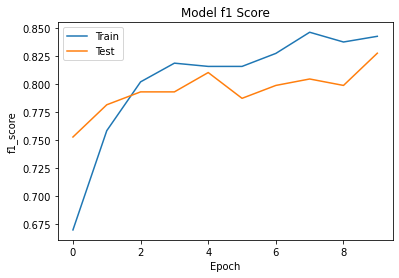

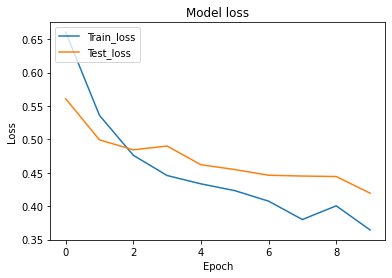

In [40]:
plot_prediction(10, hist_model1_final)

In [41]:
pred_y = model_1_final.predict(X_test)

target_names = ["Normal", "Abnormal"]


print(classification_report(y_test.argmax(axis=1), pred_y.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.77      0.90      0.83        82
    Abnormal       0.90      0.76      0.82        92

    accuracy                           0.83       174
   macro avg       0.83      0.83      0.83       174
weighted avg       0.84      0.83      0.83       174



In [42]:
F1_Score = f1_score(y_test.argmax(axis=1), pred_y.argmax(axis=1), average='macro')
F1_Score

0.8274950429610046

In [43]:
cm = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), 
                                       pred_y.argmax(axis=1)), index= target_names, columns=target_names)
cm

,Normal,Abnormal
Normal,74,8
Abnormal,22,70


## Modelo 2

Definimos una función que nos permita probar múltiples parámetros para el modelo 2, cargando los pesos del modelo 1. Esta vez probaremos solamente los optimizadores que tuvieron un mejor rendimiento en la tabla del modelo 1

In [ ]:
def HyperParameter_tunning_Model2(optimizer, learning_rate, metric, epochs, batch_size, 
                                  X_train, y_train, X_test, y_test):
    
    start_time = time.time()

    ### Cargamos el modelo base
    baseModel = EfficientNetB0(include_top=False, weights="imagenet", classes=2, input_shape = (224,224,3))
    baseModel.trainable = False

    #Activamos las últimas 20 capaz excepto las Batch Normalization
    r = re.compile(".*bn$")
    for layer in baseModel.layers[-20:]:
      layerName = layer.name
      if r.match(layerName): 
        layer.trainable = False
        #print(layer.name)
      else:
        layer.trainable =True


    model_2 = baseModel.output
    model_2 = GlobalMaxPooling2D()(model_2)
    model_2 = layers.BatchNormalization()(model_2)
    model_2 = Dropout(0.20)(model_2)
    model_2 = Dense(2, activation='softmax')(model_2)
    model_2 = Model(inputs=baseModel.inputs, outputs = model_2)
    model_2.load_weights("Model_Results/Model1_Final_Wgts.hdf5")
    
    optimizer = optimizer(learning_rate=learning_rate)
    model_2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[metric])
    
    epochs = epochs
    batch_size = batch_size
    
    hist_model = model_2.fit(X_train,
                          y_train,
                          epochs=epochs,
                          validation_data=(X_test,y_test),
                          batch_size=batch_size,
                          verbose=0)
    
    pred_y = model_2.predict(X_test)
    target_names = ["Normal", "Abnormal"]
    cm = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), 
                                       pred_y.argmax(axis=1)), index= target_names, columns=target_names)
    
    Accuracy = accuracy_score(y_test.argmax(axis=1), 
                              pred_y.argmax(axis=1))
    F1_Score = f1_score(y_test.argmax(axis=1), pred_y.argmax(axis=1), average='macro')
    
    
    end_time = time.time() - start_time

    
    results = {
        
        "Model Configuration": {'Optimizer': optimizer, 
                                'Learning Rate': learning_rate, 
                                'Metric': metric, 
                                'Epochs': epochs,  
                                'Batch Size': batch_size},
                                                                                                                 
        'Model': model_2,
        'History': hist_model,
        'Matriz de Confusión': cm,
        'Accuracy': Accuracy,
        'f1_score': F1_Score,
        'Time Seconds': end_time
    }
    return results

Ejecutamos la función, probando diferentes learning rates batch sizes y número de épocas.

In [ ]:
lr = [0.0001, 
      0.001, 
      #0.01, 
      #0.05, 
      #0.1
      ]

opt = [
       tf.keras.optimizers.Adam, 
       tf.keras.optimizers.SGD]

batch_sizes = [16,
               32,64
               ]

epochs = [
          10,50,100
          ]


start_time = time.time()

models_2 = []
progress = 0

for i in lr:
    for e in opt:
        for o in batch_sizes:
            for u in epochs:
                
                results = HyperParameter_tunning_Model2(e, i,
                                                        'accuracy', u, o, 
                                                        X_train, y_train, X_test, y_test)
                models_2.append(results)
                progress +=1
                print("Modelo numero: {}, time: {}, config: {}, {}, {}, {}".format(progress, (time.time() - start_time), i,e,o,u))
                

end_time = time.time() - start_time
print(end_time)

Modelo numero: 1, time: 44.30306529998779, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 16, 10
Modelo numero: 2, time: 224.44589400291443, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 16, 50
Modelo numero: 3, time: 577.1112732887268, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 16, 100
Modelo numero: 4, time: 619.1663794517517, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 32, 10
Modelo numero: 5, time: 788.0088310241699, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 32, 50
Modelo numero: 6, time: 1113.5519230365753, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 32, 100
Modelo numero: 7, time: 1155.3475680351257, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 64, 10
Modelo numero: 8, time: 1311.5464589595795, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 64, 50
Modelo numero: 9, time: 1610.2319827079773, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 64, 100
Modelo numero: 10, time: 1654.27693271

In [ ]:
finalData_Model2 = []

for u, o in enumerate(models_2):
    ModelResult = pd.json_normalize(models_2[u]["Model Configuration"])
    ModelResult["Accuracy"] = models_2[u]["Accuracy"]
    ModelResult["F1_Score"] = models_2[u]["f1_score"]
    ModelResult["Time"] = models_2[u]['Time Seconds']

    finalData_Model2.append(ModelResult)

FinalResultsModel2 = pd.concat(finalData_Model2)
FinalResultsModel2 = FinalResultsModel2.sort_values(by = ["F1_Score", "Accuracy", "Time"], ascending  = False)

FinalResultsModel2.to_csv("resultsModel2.csv", index=False, sep="|")
FinalResultsModel2.head(25)

,Optimizer,Learning Rate,Metric,Epochs,Batch Size,Accuracy,F1_Score,Time
0,<keras.optimizer_v2.adam.Adam object at 0x7f0fd5b52210>,0.0001,accuracy,100,64,0.913793,0.913790,298.684126
0,<keras.optimizer_v2.adam.Adam object at 0x7f0fd6a9e7d0>,0.0001,accuracy,50,64,0.908046,0.908034,156.198314
0,<keras.optimizer_v2.adam.Adam object at 0x7f0f2ee70950>,0.0010,accuracy,100,16,0.908046,0.908034,348.040825
0,<keras.optimizer_v2.adam.Adam object at 0x7f0f1e8776d0>,0.0010,accuracy,50,64,0.908046,0.907997,154.524478
0,<keras.optimizer_v2.adam.Adam object at 0x7f0fe1defe90>,0.0001,accuracy,50,16,0.902299,0.902296,180.142285
0,<keras.optimizer_v2.adam.Adam object at 0x7f0f283f1fd0>,0.0010,accuracy,50,32,0.902299,0.902037,167.933455
0,<keras.optimizer_v2.adam.Adam object at 0x7f0fdb7c6190>,0.0001,accuracy,100,16,0.890805,0.890801,352.664774
0,<keras.optimizer_v2.adam.Adam object at 0x7f110ab9c590>,0.0001,accuracy,50,32,0.885057,0.884921,168.841093
0,<keras.optimizer_v2.adam.Adam object at 0x7f0f2c180910>,0.0010,accuracy,10,32,0.867816,0.867074,41.714443
0,<keras.optimizer_v2.gradient_descent.SGD object at 0x7f0f11f65250>,0.0010,accuracy,100,16,0.862069,0.861905,347.644347


El mejor resultado lo obtuvimos a partir de la siguiente configuración:
- Optimizador: Adam
- Épocas: 100
- Batch size: 64


Por lo tanto procede a armar el modelo final número 2 para presentar el reporte de clasificación y matriz de confusión. 

In [44]:
start_time = time.time()

baseModel = EfficientNetB0(include_top=False, weights="imagenet", classes=2, input_shape = (224,224,3))
baseModel.trainable = False


#Activamos las últimas 20 capaz excepto las Batch Normalization
r = re.compile(".*bn$")
for layer in baseModel.layers[-20:]:
  layerName = layer.name
  if r.match(layerName):
    layer.trainable = False
        #print(layer.name)
  else:
    layer.trainable =True

model_2_final = baseModel.output
model_2_final = GlobalMaxPooling2D()(model_2_final)
model_2_final = layers.BatchNormalization()(model_2_final)
model_2_final = Dropout(0.20)(model_2_final)
model_2_final = Dense(2, activation='softmax')(model_2_final)


model_2_final = Model(inputs=baseModel.inputs, outputs = model_2_final)
model_2_final.load_weights("Model_Results/Model1_Final_Wgts.hdf5")

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00010)
# Compile
model_2_final.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[tfa.metrics.F1Score(num_classes = 2, average = 'micro')])


epochs = 100
batch_size = 64

hist_model2_final = model_2_final.fit(X_train, y_train,
                                epochs=epochs,
                                validation_data=(X_test, y_test),
                                batch_size=batch_size)

model_2_final.save_weights('Model_Results/Model2_Final_Wgts.hdf5')

end_time = time.time() - start_time
print(end_time)


Epoch 1/100
22/22 [==============================] - 14s 274ms/step - loss: 0.3575 - f1_score: 0.8579 - val_loss: 0.3860 - val_f1_score: 0.8448
Epoch 2/100
22/22 [==============================] - 3s 136ms/step - loss: 0.3013 - f1_score: 0.8774 - val_loss: 0.4352 - val_f1_score: 0.8161
Epoch 3/100
22/22 [==============================] - 3s 136ms/step - loss: 0.2698 - f1_score: 0.8978 - val_loss: 0.4078 - val_f1_score: 0.8333
Epoch 4/100
22/22 [==============================] - 3s 137ms/step - loss: 0.2483 - f1_score: 0.9036 - val_loss: 0.3979 - val_f1_score: 0.8391
Epoch 5/100
22/22 [==============================] - 3s 139ms/step - loss: 0.2180 - f1_score: 0.9173 - val_loss: 0.3606 - val_f1_score: 0.8621
Epoch 6/100
22/22 [==============================] - 3s 140ms/step - loss: 0.2029 - f1_score: 0.9326 - val_loss: 0.3513 - val_f1_score: 0.8793
Epoch 7/100
22/22 [==============================] - 3s 139ms/step - loss: 0.1883 - f1_score: 0.9347 - val_loss: 0.3956 - val_f1_score: 0.833

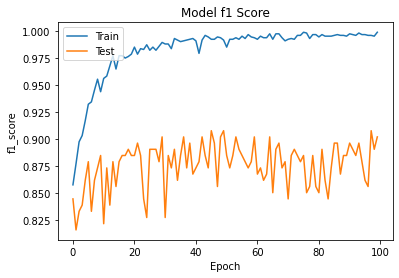

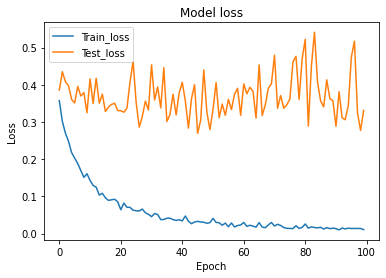

In [45]:
plot_prediction(100, hist_model2_final)

In [46]:
pred_y = model_2_final.predict(X_test)

target_names = ["Normal", "Abnormal"]


print(classification_report(y_test.argmax(axis=1), pred_y.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.85      0.96      0.90        82
    Abnormal       0.96      0.85      0.90        92

    accuracy                           0.90       174
   macro avg       0.91      0.91      0.90       174
weighted avg       0.91      0.90      0.90       174



In [47]:
F1_Score = f1_score(y_test.argmax(axis=1), pred_y.argmax(axis=1), average='macro')
F1_Score

0.9022956234516928

In [48]:
cm = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), 
                                       pred_y.argmax(axis=1)), index= target_names, columns=target_names)
cm

,Normal,Abnormal
Normal,79,3
Abnormal,14,78


## Modelo 3

Al igual que en los pasos previos, generamos una función para encontrar el mejor modelo 3, utilzando los pesos previamente guardados del modelo 2 y seteando la la EfficientNet a **trainable**

In [ ]:
def HyperParameter_tunning_Model3(optimizer, learning_rate, metric, epochs, batch_size, 
                                  X_train, y_train, X_test, y_test):
    
    start_time = time.time()

    ### Cargamos el modelo base
    baseModel = EfficientNetB0(include_top=False, weights="imagenet", classes=2, input_shape = (224,224,3))
    baseModel.trainable = True


    model_3 = baseModel.output
    model_3 = GlobalMaxPooling2D()(model_3)
    model_3 = layers.BatchNormalization()(model_3)
    model_3 = Dropout(0.20)(model_3)
    model_3 = Dense(2, activation='softmax')(model_3)
    model_3 = Model(inputs=baseModel.inputs, outputs = model_3)
    model_3.load_weights("Model_Results/Model2_Final_Wgts.hdf5")
    
    optimizer = optimizer(learning_rate=learning_rate)
    model_3.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[metric])
    
    epochs = epochs
    batch_size = batch_size
    
    hist_model = model_3.fit(X_train,
                          y_train,
                          epochs=epochs,
                          validation_data=(X_test,y_test),
                          batch_size=batch_size,
                          verbose=0)
    
    pred_y = model_3.predict(X_test)
    target_names = ["Normal", "Abnormal"]
    cm = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), 
                                       pred_y.argmax(axis=1)), index= target_names, columns=target_names)
    
    Accuracy = accuracy_score(y_test.argmax(axis=1), 
                              pred_y.argmax(axis=1))
    F1_Score = f1_score(y_test.argmax(axis=1), pred_y.argmax(axis=1), average='macro')
    
    
    end_time = time.time() - start_time

    
    results = {
        
        "Model Configuration": {'Optimizer': optimizer, 
                                'Learning Rate': learning_rate, 
                                'Metric': metric, 
                                'Epochs': epochs,  
                                'Batch Size': batch_size},
                                                                                                                 
        'Model': model_3,
        'History': hist_model,
        'Matriz de Confusión': cm,
        'Accuracy': Accuracy,
        'f1_score': F1_Score,
        'Time Seconds': end_time
    }
    return results

Ejecutamos la función, probando diferentes learning rates, batch size y épocas:

In [ ]:
lr = [
      #0.000001,
      #0.00001,
      0.0001, 
      0.001, 
      #0.01, 
      #0.05, 
      #0.1
      ]

opt = [
       tf.keras.optimizers.Adam, 
       #tf.keras.optimizers.SGD
       ]

batch_sizes = [16,
               32,64
               ]

epochs = [
          50,100
          ]


start_time = time.time()

models_3 = []
progress = 0

for i in lr:
    for e in opt:
        for o in batch_sizes:
            for u in epochs:
                
                results = HyperParameter_tunning_Model3(e, i,
                                                        'accuracy', u, o, 
                                                        X_train, y_train, X_test, y_test)
                models_3.append(results)
                progress +=1
                print("Modelo numero: {}, time: {}, config: {}, {}, {}, {}".format(progress, (time.time() - start_time), i,e,o,u))
                

end_time = time.time() - start_time
print(end_time)

Modelo numero: 1, time: 694.199387550354, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 16, 50
Modelo numero: 2, time: 2073.7617135047913, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 16, 100
Modelo numero: 3, time: 2741.999196767807, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 32, 50
Modelo numero: 4, time: 4062.6237823963165, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 32, 100
Modelo numero: 5, time: 4706.064509153366, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 64, 50
Modelo numero: 6, time: 5972.031692028046, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 64, 100
Modelo numero: 7, time: 6666.368090867996, config: 0.001, <class 'keras.optimizer_v2.adam.Adam'>, 16, 50
Modelo numero: 8, time: 8036.702264547348, config: 0.001, <class 'keras.optimizer_v2.adam.Adam'>, 16, 100
Modelo numero: 9, time: 8705.225074529648, config: 0.001, <class 'keras.optimizer_v2.adam.Adam'>, 32, 50
Modelo numero: 10, time: 10031.685580968857,

Juntamos los resultados en una tabla para analizar los resultados:

In [ ]:
finalData_Model3 = []

for u, o in enumerate(models_3):
    ModelResult = pd.json_normalize(models_3[u]["Model Configuration"])
    ModelResult["Accuracy"] = models_3[u]["Accuracy"]
    ModelResult["F1_Score"] = models_3[u]["f1_score"]
    ModelResult["Time"] = models_3[u]['Time Seconds']

    finalData_Model3.append(ModelResult)

FinalResultsModel3 = pd.concat(finalData_Model3)
FinalResultsModel3 = FinalResultsModel3.sort_values(by = ["F1_Score", "Accuracy", "Time"], ascending  = False)

FinalResultsModel3.to_csv("resultsModel3.csv", index=False, sep="|")
FinalResultsModel3.head(25)

,Optimizer,Learning Rate,Metric,Epochs,Batch Size,Accuracy,F1_Score,Time
0,<keras.optimizer_v2.adam.Adam object at 0x7f164a54a610>,0.0001,accuracy,50,16,0.931034,0.930888,694.198721
0,<keras.optimizer_v2.adam.Adam object at 0x7f14de789390>,0.0001,accuracy,100,64,0.925287,0.925265,1265.965975
0,<keras.optimizer_v2.adam.Adam object at 0x7f14e1cae1d0>,0.0001,accuracy,50,64,0.919540,0.919498,643.439297
0,<keras.optimizer_v2.adam.Adam object at 0x7f14e7454090>,0.0001,accuracy,100,16,0.902299,0.902270,1379.560889
0,<keras.optimizer_v2.adam.Adam object at 0x7f14e5851910>,0.0001,accuracy,100,32,0.896552,0.896552,1320.624085
0,<keras.optimizer_v2.adam.Adam object at 0x7f13d742a110>,0.0010,accuracy,100,16,0.896552,0.896429,1370.333601
0,<keras.optimizer_v2.adam.Adam object at 0x7f127262e3d0>,0.0010,accuracy,100,32,0.890805,0.890801,1326.459945
0,<keras.optimizer_v2.adam.Adam object at 0x7f126ec41250>,0.0010,accuracy,50,64,0.879310,0.879274,638.974092
0,<keras.optimizer_v2.adam.Adam object at 0x7f15d01579d0>,0.0001,accuracy,50,32,0.873563,0.873563,668.236927
0,<keras.optimizer_v2.adam.Adam object at 0x7f126b37a4d0>,0.0010,accuracy,100,64,0.873563,0.873413,1264.748387


Entrenamos el modelo final 3 bajo los mejores parámetros encontrados en la tabla anteriormente presentada

Modelo final 3

In [73]:
start_time = time.time()

baseModel = EfficientNetB0(include_top=False, weights="imagenet", classes=2, input_shape = (224,224,3))
baseModel.trainable = True


model_3_final = baseModel.output
model_3_final = GlobalMaxPooling2D()(model_3_final)
model_3_final = layers.BatchNormalization()(model_3_final)
model_3_final = Dropout(0.20)(model_3_final)
model_3_final = Dense(2, activation='softmax')(model_3_final)


model_3_final = Model(inputs=baseModel.inputs, outputs = model_3_final)
model_3_final.load_weights("Model_Results/Model2_Final_Wgts.hdf5")

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00010)
# Compile
model_3_final.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[tfa.metrics.F1Score(num_classes = 2, average = 'micro')])


epochs = 100
batch_size = 64

hist_model3_final = model_3_final.fit(X_train, y_train,
                                epochs=epochs,
                                validation_data=(X_test, y_test),
                                batch_size=batch_size)

model_3_final.save_weights('Model_Results/Model3_Final_Wgts.hdf5')

end_time = time.time() - start_time
print(end_time)

Epoch 1/100
22/22 [==============================] - 23s 630ms/step - loss: 0.6927 - f1_score: 0.7418 - val_loss: 1.8222 - val_f1_score: 0.5977
Epoch 2/100
22/22 [==============================] - 13s 573ms/step - loss: 0.2657 - f1_score: 0.8912 - val_loss: 1.8536 - val_f1_score: 0.5517
Epoch 3/100
22/22 [==============================] - 13s 574ms/step - loss: 0.1550 - f1_score: 0.9449 - val_loss: 1.8133 - val_f1_score: 0.5345
Epoch 4/100
22/22 [==============================] - 13s 574ms/step - loss: 0.1035 - f1_score: 0.9637 - val_loss: 2.1892 - val_f1_score: 0.5287
Epoch 5/100
22/22 [==============================] - 13s 575ms/step - loss: 0.0695 - f1_score: 0.9790 - val_loss: 2.2557 - val_f1_score: 0.5287
Epoch 6/100
22/22 [==============================] - 13s 586ms/step - loss: 0.0503 - f1_score: 0.9877 - val_loss: 2.1780 - val_f1_score: 0.5287
Epoch 7/100
22/22 [==============================] - 13s 590ms/step - loss: 0.0488 - f1_score: 0.9869 - val_loss: 2.1564 - val_f1_score:

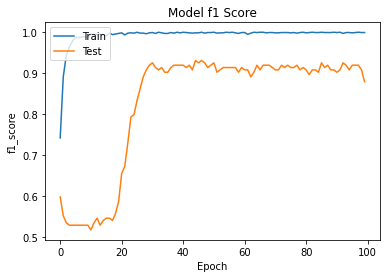

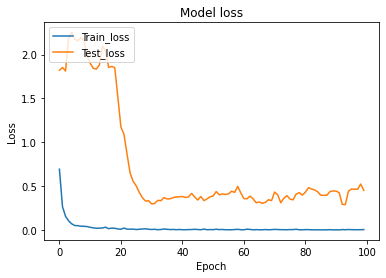

In [74]:
plot_prediction(100, hist_model3_final)

In [78]:
pred_y = model_3_final.predict(X_test)

target_names = ["Normal", "Abnormal"]

print(classification_report(y_test.argmax(axis=1), pred_y.argmax(axis=1), target_names=target_names))


              precision    recall  f1-score   support

      Normal       0.82      0.95      0.88        82
    Abnormal       0.95      0.82      0.88        92

    accuracy                           0.88       174
   macro avg       0.89      0.88      0.88       174
weighted avg       0.89      0.88      0.88       174



In [76]:
F1_Score = f1_score(y_test.argmax(axis=1), pred_y.argmax(axis=1), average='macro')
F1_Score


0.8792744573297651

In [77]:
cm = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), 
                                       pred_y.argmax(axis=1)), index= target_names, columns=target_names)
cm

,Normal,Abnormal
Normal,78,4
Abnormal,17,75


## Modelo 4

In [ ]:
def HyperParameter_tunning_Model4(optimizer, learning_rate, metric, epochs, batch_size, 
                                  X_train, y_train, X_test, y_test):
    
    start_time = time.time()

    ### Cargamos el modelo base
    baseModel = EfficientNetB0(include_top=False, weights="imagenet", classes=2, input_shape = (224,224,3))
    baseModel.trainable = True


    model_4 = baseModel.output
    model_4 = GlobalMaxPooling2D()(model_4)
    model_4 = layers.BatchNormalization()(model_4)
    model_4 = Dropout(0.20)(model_4)

    model_4 = GlobalMaxPooling2D()(model_4)
    model_4 = layers.BatchNormalization()(model_4)
    model_4 = Dropout(0.20)(model_4)

    model_4 = GlobalMaxPooling2D()(model_4)
    model_4 = layers.BatchNormalization()(model_4)
    model_4 = Dropout(0.20)(model_4)



    model_4 = Dense(2, activation='softmax')(model_4)
    model_4 = Model(inputs=baseModel.inputs, outputs = model_4)

    model_4.load_weights("Model_Results/Model3_Final_Wgts.hdf5")

    optimizer = optimizer(learning_rate=learning_rate)
    model_4.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[metric])
    
    epochs = epochs
    batch_size = batch_size
    
    hist_model = model_4.fit(X_train,
                          y_train,
                          epochs=epochs,
                          validation_data=(X_test,y_test),
                          batch_size=batch_size,
                          verbose=0)
    
    pred_y = model_4.predict(X_test)
    target_names = ["Normal", "Abnormal"]
    cm = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), 
                                       pred_y.argmax(axis=1)), index= target_names, columns=target_names)
    
    Accuracy = accuracy_score(y_test.argmax(axis=1), 
                              pred_y.argmax(axis=1))
    F1_Score = f1_score(y_test.argmax(axis=1), pred_y.argmax(axis=1), average='macro')
    
    
    end_time = time.time() - start_time

    
    results = {
        
        "Model Configuration": {'Optimizer': optimizer, 
                                'Learning Rate': learning_rate, 
                                'Metric': metric, 
                                'Epochs': epochs,  
                                'Batch Size': batch_size},
                                                                                                                 
        'Model': model_4,
        'History': hist_model,
        'Matriz de Confusión': cm,
        'Accuracy': Accuracy,
        'f1_score': F1_Score,
        'Time Seconds': end_time
    }
    return results

In [ ]:
lr = [
      0.000001,
      0.00001,
      0.0001, 
      #0.001, 
      #0.01, 
      #0.05, 
      #0.1
      ]

opt = [
       tf.keras.optimizers.Adam, 
       #tf.keras.optimizers.SGD
       ]

batch_sizes = [16,
               #32,
               64
               ]

epochs = [
          50,
          #100
          ]


start_time = time.time()

models_4 = []
progress = 0

for i in lr:
    for e in opt:
        for o in batch_sizes:
            for u in epochs:
                
                results = HyperParameter_tunning_Model4(e, i,
                                                        'accuracy', u, o, 
                                                        X_train, y_train, X_test, y_test)
                models_4.append(results)
                progress +=1
                print("Modelo numero: {}, time: {}, config: {}, {}, {}, {}".format(progress, (time.time() - start_time), i,e,o,u))
                

end_time = time.time() - start_time
print(end_time)

Modelo numero: 1, time: 705.5459489822388, config: 1e-06, <class 'keras.optimizer_v2.adam.Adam'>, 16, 50
Modelo numero: 2, time: 1347.1455900669098, config: 1e-06, <class 'keras.optimizer_v2.adam.Adam'>, 64, 50
Modelo numero: 3, time: 2040.4356858730316, config: 1e-05, <class 'keras.optimizer_v2.adam.Adam'>, 16, 50
Modelo numero: 4, time: 2677.6953978538513, config: 1e-05, <class 'keras.optimizer_v2.adam.Adam'>, 64, 50
Modelo numero: 5, time: 3373.636196374893, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 16, 50
Modelo numero: 6, time: 4006.374933719635, config: 0.0001, <class 'keras.optimizer_v2.adam.Adam'>, 64, 50
4006.3752114772797


In [ ]:
finalData_Model4 = []

for u, o in enumerate(models_4):
    ModelResult = pd.json_normalize(models_4[u]["Model Configuration"])
    ModelResult["Accuracy"] = models_4[u]["Accuracy"]
    ModelResult["F1_Score"] = models_4[u]["f1_score"]
    ModelResult["Time"] = models_4[u]['Time Seconds']

    finalData_Model4.append(ModelResult)

FinalResultsModel4 = pd.concat(finalData_Model4)
FinalResultsModel4 = FinalResultsModel4.sort_values(by = ["F1_Score", "Accuracy", "Time"], ascending  = False)

FinalResultsModel4.to_csv("resultsModel4.csv", index=False, sep="|")
FinalResultsModel4.head(25)

,Optimizer,Learning Rate,Metric,Epochs,Batch Size,Accuracy,F1_Score,Time
0,<keras.optimizer_v2.adam.Adam object at 0x7f14e4c7dc50>,0.000100,accuracy,50,16,0.925287,0.925226,695.940196
0,<keras.optimizer_v2.adam.Adam object at 0x7f14e58f2290>,0.000001,accuracy,50,16,0.908046,0.907997,705.545365
0,<keras.optimizer_v2.adam.Adam object at 0x7f13d751b1d0>,0.000010,accuracy,50,16,0.908046,0.907997,693.289512
0,<keras.optimizer_v2.adam.Adam object at 0x7f126f0e6350>,0.000001,accuracy,50,64,0.902299,0.902270,641.599045
0,<keras.optimizer_v2.adam.Adam object at 0x7f14e0856ad0>,0.000010,accuracy,50,64,0.902299,0.902270,637.259068
0,<keras.optimizer_v2.adam.Adam object at 0x7f167016f550>,0.000100,accuracy,50,64,0.879310,0.879274,632.737353


## Modelo 5

In [64]:
from tensorflow.keras.applications import EfficientNetB7

start_time = time.time()

baseModel = EfficientNetB7(include_top=False, weights="imagenet", classes=2, input_shape = (224,224,3))
baseModel.trainable = True


model_5 = baseModel.output
model_5 = GlobalMaxPooling2D()(model_5)
model_5 = layers.BatchNormalization()(model_5)
model_5 = Dropout(0.20)(model_5)
model_5 = Dense(2, activation='softmax')(model_5)


model_5 = Model(inputs=baseModel.inputs, outputs = model_5)
#model_5.load_weights("Model_Results/Model3_Final_Wgts.hdf5")

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00010)
# Compile
model_5.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=[tfa.metrics.F1Score(num_classes = 2, average = 'micro')])


epochs = 50
batch_size = 16

hist_model5 = model_5.fit(X_train, y_train,
                                epochs=epochs,
                                validation_data=(X_test, y_test),
                                batch_size=batch_size)

#hist_model5.save_weights('Model_Results/Model3_Final_Wgts.hdf5')

end_time = time.time() - start_time
print(end_time)

258088960/258076736 [==============================] - 8s 0us/step
Epoch 1/50
87/87 [==============================] - 126s 1s/step - loss: 0.5448 - f1_score: 0.7672 - val_loss: 0.7191 - val_f1_score: 0.6437
Epoch 2/50
87/87 [==============================] - 83s 958ms/step - loss: 0.2101 - f1_score: 0.9246 - val_loss: 0.9042 - val_f1_score: 0.6494
Epoch 3/50
87/87 [==============================] - 84s 962ms/step - loss: 0.1050 - f1_score: 0.9703 - val_loss: 0.5917 - val_f1_score: 0.7701
Epoch 4/50
87/87 [==============================] - 84s 962ms/step - loss: 0.0709 - f1_score: 0.9833 - val_loss: 0.3616 - val_f1_score: 0.8908
Epoch 5/50
87/87 [==============================] - 83s 955ms/step - loss: 0.0755 - f1_score: 0.9768 - val_loss: 0.2759 - val_f1_score: 0.9023
Epoch 6/50
87/87 [==============================] - 83s 957ms/step - loss: 0.0400 - f1_score: 0.9869 - val_loss: 0.2794 - val_f1_score: 0.9023
Epoch 7/50
87/87 [==============================] - 83s 958ms/step - loss: 0.

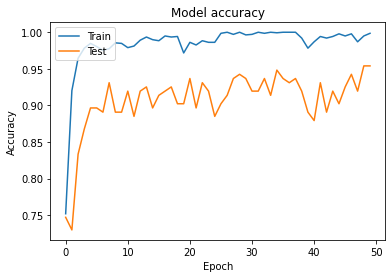

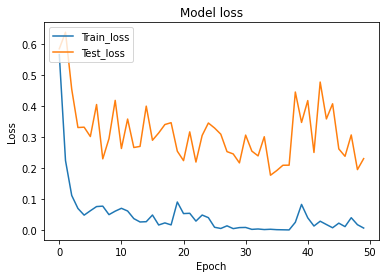

In [ ]:
plot_prediction(50, hist_model5)

In [ ]:
pred_y = model_5.predict(X_test)

target_names = ["Normal", "Abnormal"]


print(classification_report(y_test.argmax(axis=1), pred_y.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.94      0.96      0.95        82
    Abnormal       0.97      0.95      0.96        92

    accuracy                           0.95       174
   macro avg       0.95      0.95      0.95       174
weighted avg       0.95      0.95      0.95       174



In [ ]:
cm = pd.DataFrame(confusion_matrix(y_test.argmax(axis=1), 
                                       pred_y.argmax(axis=1)), index= target_names, columns=target_names)
cm

,Normal,Abnormal
Normal,79,3
Abnormal,5,87


# Sección 3


In [ ]:
def crossValCNN(folderName, dfTotal):

    FolderNumber = df[(df["Folder"] == str(folderName))]

    ## Desordenamos los datos
    FolderNumber = FolderNumber.sample(FolderNumber.shape[0], random_state=42)

    ## Transformamos la condicion a 0 y 1.
    FolderNumber['Condition'] = FolderNumber['Condition'].replace(['normal'], 0)
    FolderNumber['Condition'] = FolderNumber['Condition'].replace(['abnormal'],1)

    testDF = FolderNumber[FolderNumber["Train_Test_Valid"] == 'test']
    trainDF = FolderNumber[FolderNumber["Train_Test_Valid"] == 'train']
    validDF = FolderNumber[FolderNumber["Train_Test_Valid"] == 'valid']

    y_test = tf.keras.utils.to_categorical(np.array(testDF["Condition"]))
    y_train = tf.keras.utils.to_categorical(np.array(trainDF["Condition"]))
    y_valid = tf.keras.utils.to_categorical(np.array(validDF["Condition"]))

    X_train = np.array([plt.imread(i) for i in trainDF["ImgsPaths"]])
    X_test = np.array([plt.imread(i) for i in testDF["ImgsPaths"]])
    X_valid = np.array([plt.imread(i) for i in validDF["ImgsPaths"]])

    baseModel = EfficientNetB0(include_top=False, weights="imagenet", classes=2, input_shape = (224,224,3))
    baseModel.trainable = True

    model_final = baseModel.output
    model_final = GlobalMaxPooling2D()(model_final)
    model_final = layers.BatchNormalization()(model_final)
    model_final = Dropout(0.20)(model_final)
    model_final = Dense(2, activation='softmax')(model_final)

    model_final = Model(inputs=baseModel.inputs, outputs = model_final)
    model_final.load_weights("Model_Results/Model2_Final_Wgts.hdf5")

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00010)
    # Compile
    model_final.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])

    epochs = 50
    batch_size = 16

    start_time = time.time()
    print("Fitting Model with : {}".format(folderName))

    hist_model_final = model_final.fit(X_train, y_train,
                                      epochs=epochs,
                                      validation_data=(X_test, y_test),
                                      batch_size=batch_size, verbose=0)


    end_time = time.time() - start_time

    pred_y = model_final.predict(X_test)
    pred_y_valid = model_final.predict(X_valid)
    
    
    Accuracy = accuracy_score(y_test.argmax(axis=1), pred_y.argmax(axis=1))
    F1_Score = f1_score(y_test.argmax(axis=1), pred_y.argmax(axis=1), average='macro')

    Accuracy_Valid = accuracy_score(y_valid.argmax(axis=1), pred_y_valid.argmax(axis=1))
    F1_Score_Valid = f1_score(y_valid.argmax(axis=1), pred_y_valid.argmax(axis=1), average='macro')
    
    results = {
        
        'History': hist_model_final,
        'Accuracy': Accuracy,
        'f1_score': F1_Score,
        'Accuracy_Validacion': Accuracy_Valid,
        'f1_score_Validacion': F1_Score_Valid,
        'Time Seconds': end_time,
        'Folder': folderName
    }

    #print(results)

    return results

In [ ]:
foldersNames = df.Folder.unique()
foldersNames

array(['Fold3', 'Fold7', 'Fold9', 'Fold1', 'Fold0', 'Fold2', 'Fold4',
       'Fold8', 'Fold5', 'Fold6'], dtype=object)

In [ ]:
df.head()

,ImgsPaths,Folder,Train_Test_Valid,Condition
0,data/practica_DL_UOC_2022/Fold3/test/normal/RJkbMYUrXl.jpg,Fold3,test,normal
1,data/practica_DL_UOC_2022/Fold3/test/normal/EMpNLPsRUu.jpg,Fold3,test,normal
2,data/practica_DL_UOC_2022/Fold3/test/normal/zEYMCPLPaq.jpg,Fold3,test,normal
3,data/practica_DL_UOC_2022/Fold3/test/normal/kCChKhUIpS.jpg,Fold3,test,normal
4,data/practica_DL_UOC_2022/Fold3/test/normal/RyGNHJNtHj.jpg,Fold3,test,normal


In [ ]:
df.shape

(17090, 4)

In [ ]:
finalResults = []

for i in list(foldersNames):
  executionCross = crossValCNN(i, df)
  data = pd.json_normalize(executionCross)
  finalResults.append(data)

finalResultsDF = pd.concat(finalResults) 

Fitting Model with : Fold3
Fitting Model with : Fold7
Fitting Model with : Fold9
Fitting Model with : Fold1
Fitting Model with : Fold0
Fitting Model with : Fold2
Fitting Model with : Fold4
Fitting Model with : Fold8
Fitting Model with : Fold5
Fitting Model with : Fold6


In [ ]:
finalResultsDF.to_csv("finalResultsDF.csv", index=False, sep="|")

In [ ]:
finalResultsDF.sort_values(by="Folder")

,History,Accuracy,f1_score,Accuracy_Validacion,f1_score_Validacion,Time Seconds,Folder
0,<keras.callbacks.History object at 0x7febda02a210>,0.873563,0.873547,0.915584,0.913985,532.540730,Fold0
0,<keras.callbacks.History object at 0x7febdd864090>,0.942529,0.942407,0.902597,0.901664,529.122744,Fold1
0,<keras.callbacks.History object at 0x7febd687a590>,0.902299,0.900239,0.922078,0.920999,534.651769,Fold2
0,<keras.callbacks.History object at 0x7fede0249490>,0.856322,0.855246,0.902597,0.901898,531.803058,Fold3
0,<keras.callbacks.History object at 0x7febd3087ed0>,0.913793,0.913148,0.902597,0.902396,531.515771,Fold4
0,<keras.callbacks.History object at 0x7febce4b86d0>,0.879310,0.878987,0.961039,0.960801,525.484813,Fold5
0,<keras.callbacks.History object at 0x7febc8854c50>,0.919540,0.919444,0.935065,0.934166,528.777417,Fold6
0,<keras.callbacks.History object at 0x7fed4703dc90>,0.948276,0.946346,0.941558,0.941139,532.103657,Fold7
0,<keras.callbacks.History object at 0x7febd0bf3490>,0.896552,0.895878,0.909091,0.908099,527.929732,Fold8
0,<keras.callbacks.History object at 0x7fed44232c50>,0.925287,0.921749,0.863636,0.863492,532.995880,Fold9


***

In [ ]:
finalResultsDF["Accuracy"].mean()
finalResultsDF["f1_score"].mean()
finalResultsDF["Accuracy_Validacion"].mean()
finalResultsDF["f1_score_Validacion"].mean()
finalResultsDF["Time Seconds"].mean()

530.6925570726395

In [ ]:
finalResultsDF.describe().T

,count,mean,std,min,25%,50%,75%,max
Accuracy,10.0,0.905747,0.029949,0.856322,0.883621,0.908046,0.923851,0.948276
f1_score,10.0,0.904699,0.029648,0.855246,0.883209,0.906694,0.921173,0.946346
Accuracy_Validacion,10.0,0.915584,0.026686,0.863636,0.902597,0.912338,0.931818,0.961039
f1_score_Validacion,10.0,0.914864,0.026654,0.863492,0.902023,0.911042,0.930874,0.960801
Time Seconds,10.0,530.692557,2.772571,525.484813,528.863748,531.659415,532.431462,534.651769
